## Gait Video Study 
### 1D Convolutional neural network (CNN) on subject generalization frameworks, namely a) W, b) WT, c) VBW and d) VBWT,  to classify HOA/MS/PD strides and subjects using cross validation 
#### Remember to add the original count of frames in a single stride (before down sampling via smoothing) for each stride as an additional artificial feature to add information about speed of the subject to the model
1. Save the optimal hyperparameters, confusion matrices and ROC curves for each algorithm.
2. Make sure to not use x, y, z, confidence = 0, 0, 0, 0 as points for the model since they are simply missing values and not data points, so make sure to treat them before inputting to model 
3. Make sure to normalize (z-score normalization) the features before we feed them to the model.
4. We use Group 5-fold stratified cross validation for evaluation.
5. Compare 1D CNN among the 4 sub-frameworks of subject generalization by retaining only common subjets across the 4 frameworks.
6. Plot the training and testing loss vs. epochs and maybe training and testing accuracy vs. epochs. 
7. Try both z-score and min-max normalizations. Compute the training data min (using bottom 1 percentile of training data ) and max (using top 1 percentile of training data) for min-max normalization to avoid extreme outliers influencing the min/max value for normalization.
8. Try appending speed of stride in the begining along with 20x36 grid of body coordinates to process the label and appending speed after 20x36 grid is processed to a feature set represeting body coordinates and then using linear layers to process the label 

In [ ]:
from importlib import reload
import imports 
reload(imports)
from imports import *
from split import StratifiedGroupKFold

### Utility functions 

In [3]:
def set_random_seed(seed_value, use_cuda):
    '''
    To set the random seed for reproducibility of results 
    Arguments: seed value and use cuda (True if cuda is available)
    '''
    random.seed(seed_value)
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    if use_cuda: 
        torch.cuda.manual_seed_all(seed_value) # gpu vars

In [4]:
def evaluate(model, test_features, yoriginal_, ypredicted_, framework, model_name):
    '''
    Arguments: trained model, test set, true and predicted labels for test set, framework and model name 
    Returns: predicted probabilities and labels for each class, stride and subject based evaluation metrics 
    Saves the csv files for stride wise predictions and subject wise predictions for confusion matrix 
    '''
    #For creating the stride wise confusion matrix, we append the true and predicted labels for strides in each fold to this 
    #test_strides_true_predicted_labels dataframe 
    test_strides_true_predicted_labels = pd.DataFrame()
    #For creating the subject wise confusion matrix, we append the true and predicted labels for subjects in each fold to this
    #test_subjects_true_predicted_labels dataframe
    test_subjects_true_predicted_labels = pd.DataFrame()
    
    best_index = model.cv_results_['mean_test_accuracy'].argmax()
    print('best_params: ', model.cv_results_['params'][best_index])

    #Stride-wise metrics 
    stride_metrics_mean, stride_metrics_std = [], [] #Mean and SD of stride based metrics - Acc, P, R, F1, AUC (in order)
    scores={'accuracy': make_scorer(acc), 'precision':make_scorer(precision_score, average = 'macro'), \
            'recall':make_scorer(recall_score, average = 'macro'), 'f1': make_scorer(f1_score, average = 'macro'), \
           'auc': make_scorer(roc_auc_score, average = 'macro', multi_class = 'ovo', needs_proba= True)}
    
    for score in scores:
        stride_metrics_mean.append(model.cv_results_['mean_test_'+score][best_index])
        stride_metrics_std.append(model.cv_results_['std_test_'+score][best_index])
    print('Stride-based model performance (mean): ', stride_metrics_mean)
    print('Stride-based model performance (standard deviation): ', stride_metrics_std)
    n_folds = 5
    person_acc, person_p, person_r, person_f1, person_auc = [], [], [], [], []

    for i in range(n_folds):
        #For each fold, there are 2 splits: test and train (in order) and we need to retrieve the index 
        #of only test set for required 5 folds (best index)
        temp = test_features.loc[yoriginal_[(best_index*n_folds) + (i)].index] #True labels for the test strides in each fold
        temp['pred'] = ypredicted_[(best_index*n_folds) + (i)] #Predicted labels for the strides in the test set in each fold
#         print ('temp_pred', temp['pred'])
        #Appending the test strides' true and predicted label for each fold to compute stride-wise confusion matrix 
        test_strides_true_predicted_labels = test_strides_true_predicted_labels.append(temp)
        
        x = temp.groupby('PID')['pred'].value_counts().unstack()
#         print ('x', x)
        #Input for subject wise AUC is probabilities at columns [0, 1, 2]
        proportion_strides_correct = pd.DataFrame(columns = [0, 1, 2])
        probs_stride_wise = x.divide(x.sum(axis = 1), axis = 0).fillna(0)
        proportion_strides_correct[probs_stride_wise.columns] = probs_stride_wise
        proportion_strides_correct.fillna(0, inplace=True)
        proportion_strides_correct['True Label'] = test_features.groupby('PID').first()
        #Input for precision, recall and F1 score
        proportion_strides_correct['Predicted Label'] = proportion_strides_correct[[0, 1, 2]].idxmax(axis = 1) 
        #Appending the test subjects' true and predicted label for each fold to compute subject-wise confusion matrix 
        test_subjects_true_predicted_labels = test_subjects_true_predicted_labels.append(proportion_strides_correct)          
            
        #Person wise metrics for each fold 
        person_acc.append(accuracy_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label']))
        person_p.append(precision_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                       average = 'macro'))
        person_r.append(recall_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                    average = 'macro'))
        person_f1.append(f1_score(proportion_strides_correct['Predicted Label'], proportion_strides_correct['True Label'], \
                                  average = 'macro'))
        person_auc.append(roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct[[0, 1, 2]], \
                                        multi_class = 'ovo', average= 'macro'))

    #Mean and standard deviation for person-based metrics 
    person_means = [np.mean(person_acc), np.mean(person_p), np.mean(person_r), np.mean(person_f1), np.mean(person_auc)]
    person_stds = [np.std(person_acc), np.std(person_p), np.std(person_r), np.std(person_f1), np.std(person_auc)]
    print('Person-based model performance (mean): ', person_means)
    print('Person-based model performance (standard deviation): ', person_stds)
    
    #Saving the stride and person wise true and predicted labels for calculating the 
    #stride and subject wise confusion matrix for each model
    test_strides_true_predicted_labels.to_csv(results_path+ framework + '\\stride_wise_predictions_' + \
                                      str(model_name) + '_' + framework + '.csv')
    test_subjects_true_predicted_labels.to_csv(results_path+ framework + '\\person_wise_predictions_' + \
                                      str(model_name) + '_' + framework + '.csv')
    
    return test_subjects_true_predicted_labels, [stride_metrics_mean, stride_metrics_std, person_means, person_stds]

In [5]:
def acc(y_true,y_pred):
    '''
    Returns the accuracy 
    Saves the true and predicted labels for training and test sets
    '''
    global yoriginal, ypredicted
    yoriginal.append(y_true)
    ypredicted.append(y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

In [7]:
#ROC curves 
def plot_ROC(ml_model, test_set_true_predicted_labels, framework):
    '''
    Function to plot the ROC curve and confusion matrix for model given in ml_model name 
    Input: ml_models (name of models to plot the ROC for),  test_Y (true test set labels with PID), 
        predicted_probs_person (predicted test set probabilities for all 3 classes - HOA/MS/PD), framework (WtoWT / VBWtoVBWT)
    Plots and saves the ROC curve with individual class-wise plots and micro/macro average plots 
    '''
    n_classes = 3 #HOA/MS/PD
    cohort = ['HOA', 'MS', 'PD']
    ml_model_names = {'random_forest': 'RF', 'adaboost': 'AdaBoost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp':'MLP'}

    #Binarizing/getting dummies for the true labels i.e. class 1 is represented as 0, 1, 0
    test_features_binarize = pd.get_dummies(test_set_true_predicted_labels['True Label'].values)     
    sns.despine(offset=0)
    linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
    colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

    fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(6, 4.5))
    axes.plot([0, 1], [0, 1], linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
    # person-based prediction probabilities for class 0: HOA, 1: MS, 2: PD

    # Compute ROC curve and ROC area for each class
    tpr, fpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes): #n_classes = 3
        fpr[i], tpr[i], _ = roc_curve(test_features_binarize.iloc[:, i], test_set_true_predicted_labels.loc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        #Plotting the ROCs for the three classes separately
        axes.plot(fpr[i], tpr[i], label = cohort[i] +' ROC (AUC = '+ str(round(roc_auc[i], 3))
            +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[i], color = colors[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_features_binarize.values.ravel(),\
                                              test_set_true_predicted_labels[[0, 1, 2]].values.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    #Plotting the micro average ROC 
    axes.plot(fpr["micro"], tpr["micro"], label= 'micro average ROC (AUC = '+ str(round(roc_auc["micro"], 3))
            +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[3], color = colors[3])
    
    #Compute the macro-average ROC curve and AUC value
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) # First aggregate all false positive rates
    mean_tpr = np.zeros_like(all_fpr) # Then interpolate all ROC curves at this points
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes  # Finally average it and compute AUC
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    #Macro average AUC of ROC value 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])    
    #Plotting the macro average AUC
    axes.plot(fpr["macro"], tpr["macro"], label= 'macro average ROC (AUC = '+ str(round(roc_auc["macro"], 3))
        +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[4], color = colors[4])
    
    axes.set_ylabel('True Positive Rate')
    axes.set_title('Subject generalization '+framework + ' '+ ml_model_names[ml_model])
    plt.legend()
    # axes[1].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

    axes.set_xlabel('False Positive Rate')
    plt.tight_layout()
    plt.savefig(results_path + framework+'\\ROC_subject_generalize_' + framework + '_'+ ml_model+ '.png', dpi = 350)
    plt.show()
    
    #Plotting and saving the subject wise confusion matrix 
    plt.figure()
    confusion_matrix = pd.crosstab(test_set_true_predicted_labels['True Label'], test_set_true_predicted_labels['Predicted Label'], \
                                   rownames=['Actual'], colnames=['Predicted'], margins = True)
    sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu")
    plt.savefig(results_path + framework+'\\CFmatrix_subject_generalize_' + framework + '_'+ ml_model+ '.png', dpi = 350)
    plt.show()

In [10]:
def keep_common_PIDs(data, frameworks = ['W', 'WT', 'SLW', 'SLWT']):
    '''
    Since we need to compare across sub-frameworks, we must have same subjects across all sub-frameworks 
    Hence, if there are some subjects that are present in the one sub-frameworks, say W but not in another and vice versa, we eliminate those 
    subjects to have only common subjects acrossall subframeworks. 
    Arguments: 
        data: labels.csv file with all consolidated information,
        frameworks: list of frameworks for which common PIDs need to be filtered
    Returns: 
        common_pids: list of common PIDs/subjects across all the frameworks 
    '''
    
    original_pids = {} #Dictionary with original number of PIDs in each framework (task)
    for framework in frameworks:
        #Appending the original PIDs for each task
        original_pids[framework] = data[data.scenario==framework].PID.unique()
        print ('Original number of subjects in task', framework, 'are:', len(original_pids[framework]))

    #List of common PIDs across all frameworks
    common_pids = set(original_pids[frameworks[0]])
    for framework in frameworks[1:]:
        common_pids.intersection_update(original_pids[framework])
    common_pids = list(common_pids)
    print ('Common number of subjects across all frameworks: ', len(common_pids))
    print ('Common subjects across all frameworks: ', common_pids)
    return common_pids

### main()

### Subject generalization framework 1: walking (W) to classify HOA/MS/PD strides and subjects using cross validation 

In [8]:
#Trial W for the first framework of subject generalization
trialW = data[data['scenario']=='W']
print ('Original number of subjects in trial W for cross validation:', len(trialW['PID'].unique()))
print ('Number of subjects in trial W in each cohort:\n', trialW.groupby('PID').first()['cohort'].value_counts())

cols_to_drop = ['PID', 'key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label']
#Shuffling the cross validation stride data
trialW = shuffle(trialW, random_state = 0)
#CV for people generalize so no train-test split
X = trialW.drop(cols_to_drop, axis = 1)
Y = trialW[['PID', 'label']]

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in trial W for cross validation: ', len(trialW))
print ('HOA, MS and PD strides in trial W:\n', trialW['cohort'].value_counts())
print ('Imbalance ratio in trial W (controls:MS:PD)= 1:X:Y\n', trialW['cohort'].value_counts()/trialW['cohort'].value_counts()['HOA'])

#Defining the framework of interest
framework = 'W'

Original number of subjects in trial W for cross validation: 32
Number of subjects in trial W in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in trial W for cross validation:  1651
HOA, MS and PD strides in trial W:
 HOA    809
PD     453
MS     389
Name: cohort, dtype: int64
Imbalance ratio in trial W (controls:MS:PD)= 1:X:Y
 HOA    1.000000
PD     0.559951
MS     0.480841
Name: cohort, dtype: float64


random_forest
best_params:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 45}
Stride-based model performance (mean):  [0.5850981479328837, 0.5548339508136212, 0.5462691390448668, 0.5060654891048266, 0.7691312302686055]
Stride-based model performance (standard deviation):  [0.14197262088245197, 0.12376212790338895, 0.08354094138091868, 0.10566293769855316, 0.0908269246881742]
Person-based model performance (mean):  [0.6009523809523809, 0.5777777777777777, 0.47888888888888886, 0.49444444444444446, 0.7791666666666666]
Person-based model performance (standard deviation):  [0.1828075329528529, 0.12957670877434, 0.22510354270484417, 0.1524288945746001, 0.1708051015515912]


<Figure size 432x288 with 0 Axes>

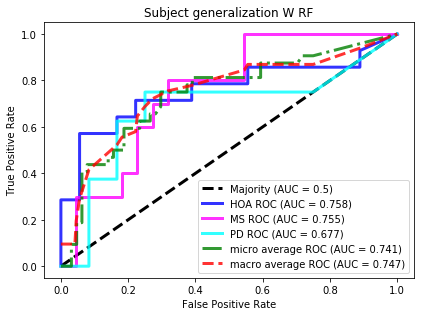

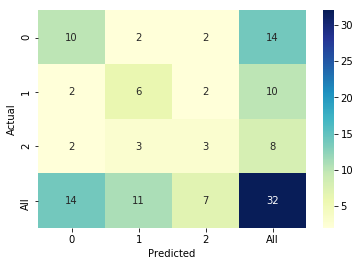

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1.5, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.5312292156979576, 0.5150662228240319, 0.4946826567027635, 0.49103486565631316, 0.7123940994796237]
Stride-based model performance (standard deviation):  [0.10120874989028403, 0.07729874462128918, 0.06962288381084072, 0.07261265087977918, 0.08088463905664775]
Person-based model performance (mean):  [0.562857142857143, 0.5444444444444444, 0.5399999999999999, 0.5055555555555555, 0.7444444444444445]
Person-based model performance (standard deviation):  [0.09629885455058697, 0.11331154474650632, 0.18587132147845767, 0.1150415920492869, 0.14016084235047627]


<Figure size 432x288 with 0 Axes>

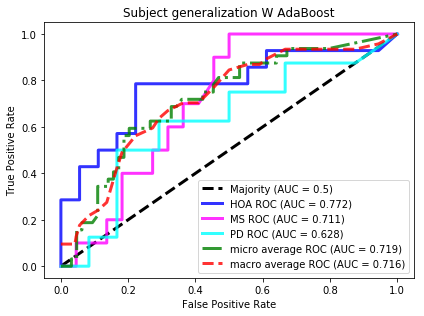

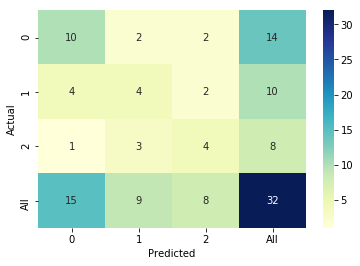

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}
Stride-based model performance (mean):  [0.5756185873350468, 0.6455733225859379, 0.4815944964705515, 0.46201466750929454, 0.7611939431249589]
Stride-based model performance (standard deviation):  [0.06499245895907965, 0.16451947756463686, 0.0471951968160351, 0.052250186323821314, 0.08605499169612758]
Person-based model performance (mean):  [0.5676190476190476, 0.5222222222222221, 0.5, 0.4766666666666667, 0.736111111111111]
Person-based model performance (standard deviation):  [0.077746025264604, 0.090267093384844, 0.11737877907772673, 0.08723460633951344, 0.0837950173833242]


<Figure size 432x288 with 0 Axes>

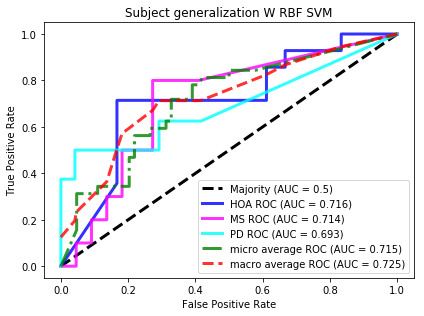

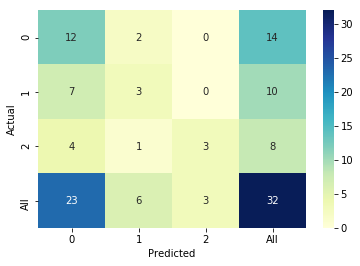

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'auto', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.6071113057911739, 0.5924132128796005, 0.5653872705275331, 0.5423056788366616, 0.7653195068315937]
Stride-based model performance (standard deviation):  [0.1244341892965032, 0.11357770872271503, 0.08626250961003107, 0.10402199534697616, 0.10959733256157414]
Person-based model performance (mean):  [0.6409523809523809, 0.6444444444444445, 0.6444444444444444, 0.6025396825396825, 0.8472222222222221]
Person-based model performance (standard deviation):  [0.15302245918777094, 0.1911627837120584, 0.23465235646603194, 0.2111471505220835, 0.1675900347666484]


<Figure size 432x288 with 0 Axes>

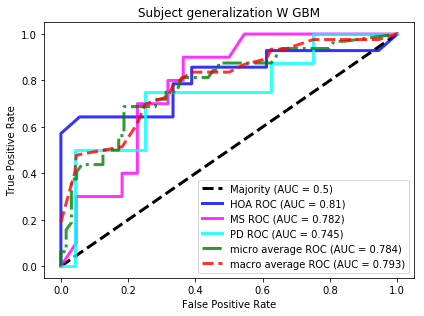

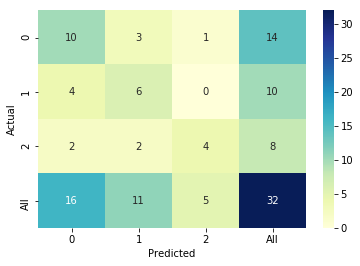

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__subsample': 0.6}
Stride-based model performance (mean):  [0.589053975653368, 0.571543270126796, 0.5420420697632509, 0.5119230136942352, 0.7565545616018234]
Stride-based model performance (standard deviation):  [0.1103766623452067, 0.09313391310893497, 0.06733694544823057, 0.07451952536352827, 0.09050865970639793]
Person-based model performance (mean):  [0.5390476190476191, 0.5111111111111111, 0.44444444444444436, 0.4358730158730159, 0.8069444444444442]
Person-based model performance (standard deviation):  [0.09535231246311487, 0.09558139185602918, 0.09938079899999067, 0.06043097088727298, 0.1373807002097582]


<Figure size 432x288 with 0 Axes>

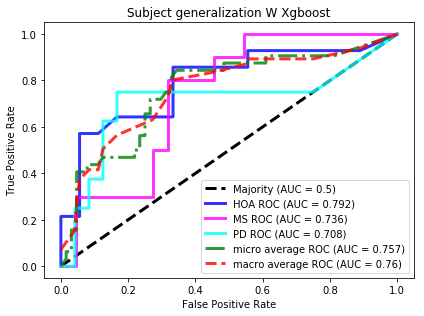

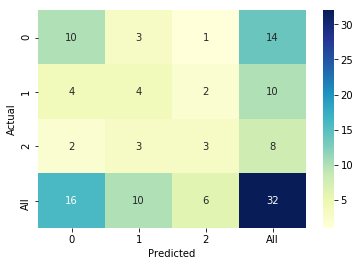

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 1}
Stride-based model performance (mean):  [0.6014415104594626, 0.5709726179303061, 0.5479209457496796, 0.5377592762235388, 0.6609407093122597]
Stride-based model performance (standard deviation):  [0.0954378061555806, 0.09935625648841995, 0.07530277986109876, 0.08128787193331043, 0.05647708489582404]
Person-based model performance (mean):  [0.62, 0.5888888888888888, 0.5455555555555556, 0.5382539682539682, 0.8166666666666667]
Person-based model performance (standard deviation):  [0.08359279336187313, 0.10886621079036347, 0.17993139982219702, 0.10014904488678834, 0.14120294474598705]


<Figure size 432x288 with 0 Axes>

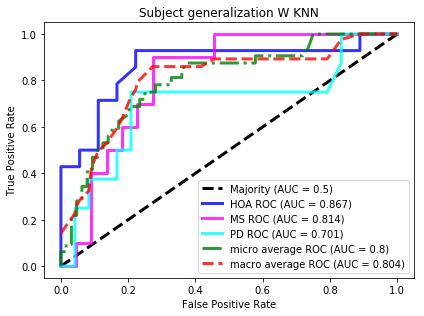

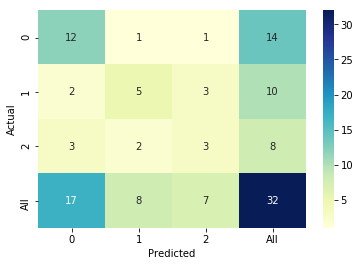

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 20}
Stride-based model performance (mean):  [0.5300318592236833, 0.5014352173893973, 0.4811543331491353, 0.4719273798190412, 0.6261066871033325]
Stride-based model performance (standard deviation):  [0.138891686311594, 0.15697474012599594, 0.11366577611624298, 0.12915939014057767, 0.09800286822635652]
Person-based model performance (mean):  [0.5438095238095239, 0.5222222222222223, 0.43888888888888883, 0.4606349206349207, 0.7027777777777777]
Person-based model performance (standard deviation):  [0.2872403688175777, 0.2548298875817715, 0.2851250537856964, 0.25564210306138296, 0.21256807188565544]


<Figure size 432x288 with 0 Axes>

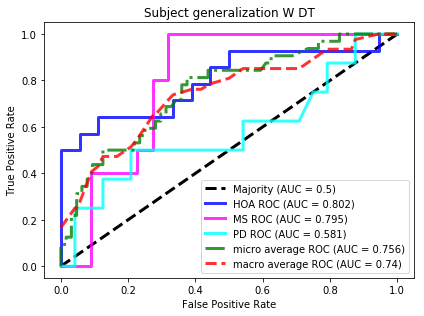

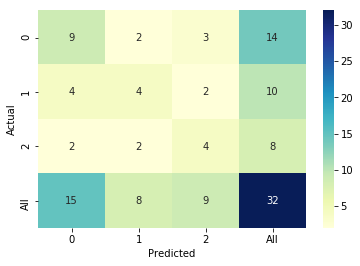

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.5957414495216629, 0.5946698461902928, 0.5625452612272918, 0.5440508026066442, 0.7373045823976163]
Stride-based model performance (standard deviation):  [0.14348680217619816, 0.14845108600703277, 0.12006122879724519, 0.1488096789163685, 0.1135176890276172]
Person-based model performance (mean):  [0.6647619047619048, 0.6555555555555556, 0.5777777777777777, 0.5892063492063493, 0.8305555555555557]
Person-based model performance (standard deviation):  [0.22011334948456718, 0.22607766610417562, 0.293131243517176, 0.26053881413514923, 0.1517388920416407]


<Figure size 432x288 with 0 Axes>

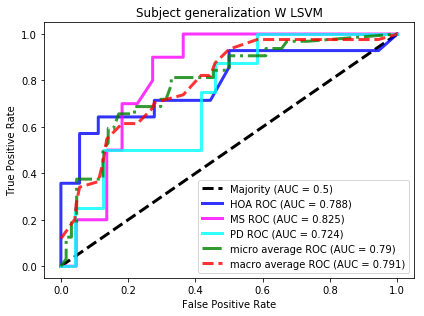

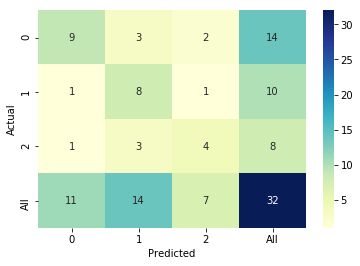

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.6073064497879757, 0.6014394517471382, 0.5871851192639117, 0.5667404990790348, 0.7486859897620752]
Stride-based model performance (standard deviation):  [0.1818032411418804, 0.18896420777995107, 0.1588848353107709, 0.18669122723864903, 0.11279697537750115]
Person-based model performance (mean):  [0.6361904761904762, 0.6222222222222222, 0.5655555555555556, 0.5593650793650793, 0.8305555555555557]
Person-based model performance (standard deviation):  [0.18044037840441968, 0.18053418676968805, 0.2655625289646931, 0.21202356814569354, 0.20363214231234728]


<Figure size 432x288 with 0 Axes>

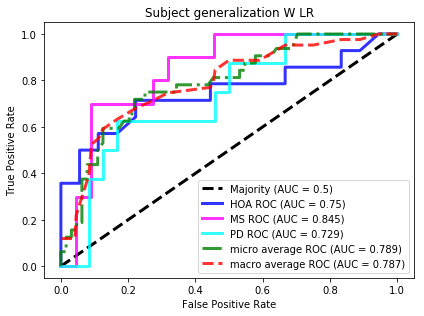

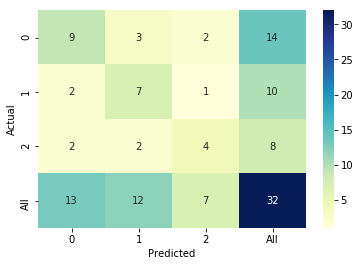

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (50, 50, 50, 10, 150, 50, 20, 20, 100)}
Stride-based model performance (mean):  [0.6053007579073946, 0.6156116433047256, 0.563641369475518, 0.5470770829408713, 0.7737691945014661]
Stride-based model performance (standard deviation):  [0.10272601827291113, 0.07401442173988657, 0.055450695527766075, 0.07176957534167135, 0.09298654238227914]
Person-based model performance (mean):  [0.6361904761904762, 0.611111111111111, 0.65, 0.5822222222222223, 0.8555555555555555]
Person-based model performance (standard deviation):  [0.12740564958621448, 0.14487116456005888, 0.17881641043812313, 0.15549205052920803, 0.14635488747021652]


<Figure size 432x288 with 0 Axes>

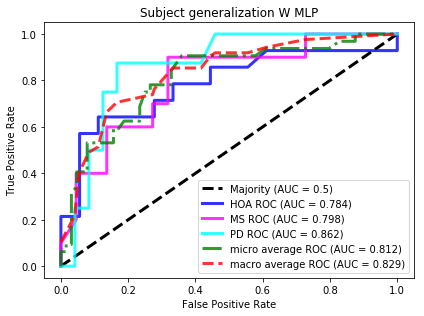

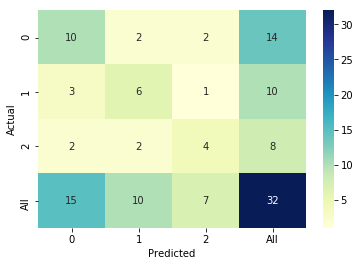

********************************


In [9]:
ml_model = 'cnn_1d'
metrics = run_ml_models(ml_models, X, Y, framework)

In [10]:
metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
stride_mean_accuracy,0.585098,0.531229,0.575619,0.607111,0.589054,0.601442,0.530032,0.595741,0.607306,0.605301
stride_mean_precision,0.554834,0.515066,0.645573,0.592413,0.571543,0.570973,0.501435,0.594670,0.601439,0.615612
stride_mean_recall,0.546269,0.494683,0.481594,0.565387,0.542042,0.547921,0.481154,0.562545,0.587185,0.563641
stride_mean_F1,0.506065,0.491035,0.462015,0.542306,0.511923,0.537759,0.471927,0.544051,0.566740,0.547077
stride_mean_AUC,0.769131,0.712394,0.761194,0.765320,0.756555,0.660941,0.626107,0.737305,0.748686,0.773769
stride_std_accuracy,0.141973,0.101209,0.064992,0.124434,0.110377,0.095438,0.138892,0.143487,0.181803,0.102726
stride_std_precision,0.123762,0.077299,0.164519,0.113578,0.093134,0.099356,0.156975,0.148451,0.188964,0.074014
stride_std_recall,0.083541,0.069623,0.047195,0.086263,0.067337,0.075303,0.113666,0.120061,0.158885,0.055451
stride_std_F1,0.105663,0.072613,0.052250,0.104022,0.074520,0.081288,0.129159,0.148810,0.186691,0.071770
stride_std_AUC,0.090827,0.080885,0.086055,0.109597,0.090509,0.056477,0.098003,0.113518,0.112797,0.092987
